In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import rc
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision.models as models
from efficientnet_pytorch import EfficientNet


# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np

## 마동석 vs 송중기 2진분류

### Augmentation

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=448, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 데이터 불러오기

In [12]:
valid_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 경로 설정
dataset_path = 'C://Users/user/Desktop/딥러닝/project_ms'

# ImageFolder를 사용하여 전체 데이터셋을 불러옵니다.
train_dataset = ImageFolder(dataset_path + '/train', transform=train_transforms)
val_dataset = ImageFolder(dataset_path + '/val', transform=valid_transforms)
# test_dataset = ImageFolder(dataset_path + '/test', transform=test_transforms)

# DataLoader 설정
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

### 데이터 라벨 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

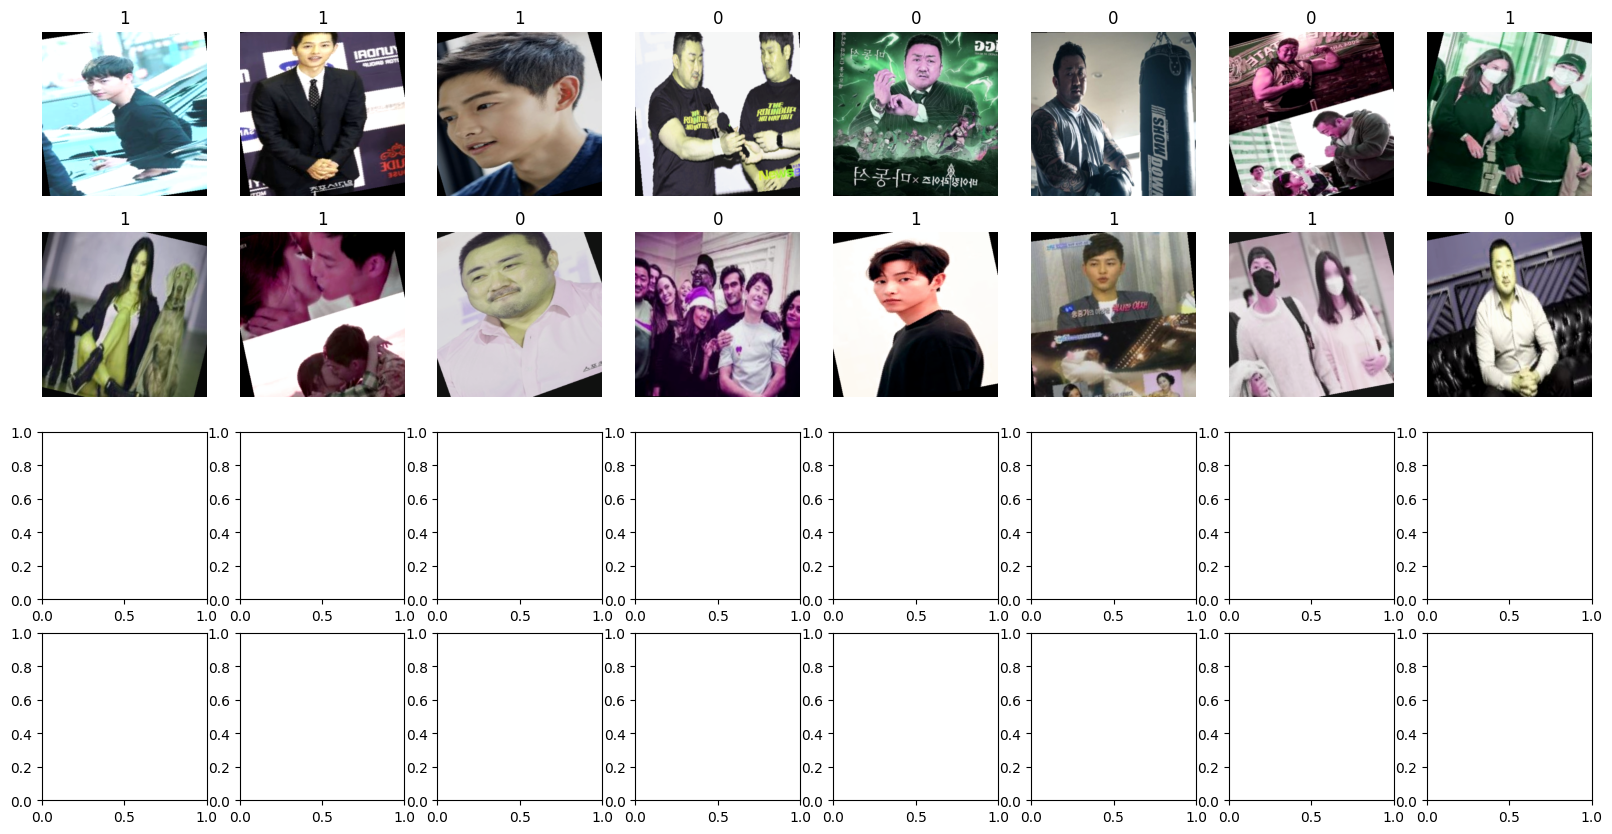

In [13]:
imgs, labels = next(iter(train_loader))

fig, axes = plt.subplots(4, 8, figsize=(20,10))

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1,2,0).numpy() * std + mean)
    ax.axis('off')

In [14]:
# 마동석:0, 송중기:1

### 마동석 vs 송중기 학습 코드

- 성능 향상 방법

#### 전체 학습 ver

In [2]:
import time

# 학습 시작 시간 기록
start_time = time.time()

model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=2)
model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 리스트 초기화
effb1_train_acc_lst = []
effb1_train_loss_lst = []
effb1_val_acc_lst = []
effb1_val_loss_lst = []

state = {}

# 모델 훈련
epochs = 50
for epoch in range(1, epochs+1):

    train_loss = 0
    total = 0
    correct = 0
    train_acc = 0

    model.train()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스 선택
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()

    train_loss = round(train_loss / len(train_loader), 3)  # 미니배치 수로 나누어 평균을 계산
    train_acc = round((train_acc / total) * 100, 2)  # 백분율로 변환

    print(f'Trainset {epoch}/{epochs} Loss: {train_loss}, Accuracy: {train_acc}%')
    effb1_train_acc_lst.append(train_acc)
    effb1_train_loss_lst.append(train_loss)

    # 검증 데이터셋에 대한 손실과 정확도 계산
    val_loss = 0
    val_total = 0
    val_correct = 0
    val_acc = 0

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_acc += (predicted == labels).sum().item()

    val_loss = round(val_loss / len(val_loader), 3)  # 검증 데이터셋의 손실 평균 계산
    val_acc = round((val_acc / val_total) * 100, 2)  # 검증 데이터셋의 정확도 계산

    print(f'Validation {epoch}/{epochs} Loss: {val_loss}, Accuracy: {val_acc}%')
    print()

    effb1_val_acc_lst.append(val_acc)
    effb1_val_loss_lst.append(val_loss)

    if np.max(effb1_val_acc_lst) <= val_acc:
        state['epoch'] = epoch
        state['net'] = model.state_dict()

        state['train_loss'] = train_loss
        state['val_loss'] = val_loss

        state['train_acc'] = train_acc
        state['val_acc'] = val_acc

end_time = time.time()

# 전체 학습 시간 계산 (종료 시간 - 시작 시간)
training_time_seconds = end_time - start_time

# 시, 분, 초로 변환
training_time_minutes = training_time_seconds // 60
training_time_hours = training_time_minutes // 60

print(f"Total training time: {training_time_seconds} seconds")
print(f"Total training time: {training_time_minutes} minutes")
print(f"Total training time: {training_time_hours} hours")
print(f"Total training time: {training_time_hours} H {training_time_minutes - (60 * training_time_hours)} m")

# 모델 저장
torch.save(state, 'C://Users/user/Desktop/딥러닝/학습모델/full_마송_448_efficientb1_{}_{}.pth'.format(str(state['epoch']), str(state['val_acc'])))

##### Acc and Loss 시각화

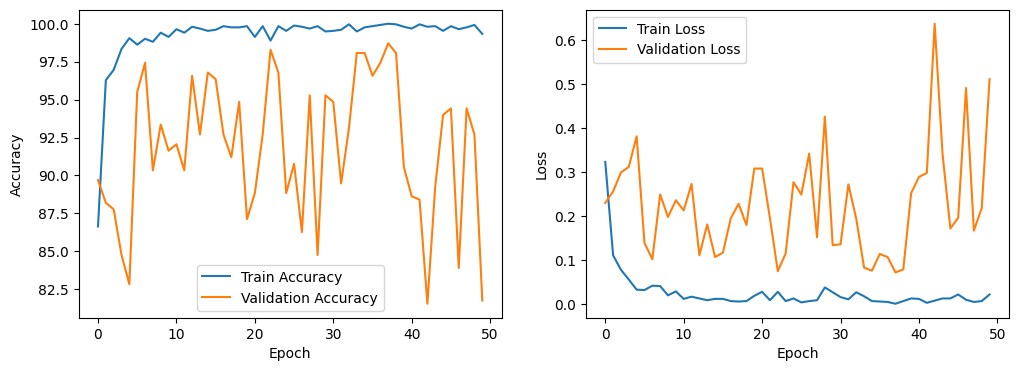

In [11]:
# 정확도 및 손실을 그래프로 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(effb1_train_acc_lst, label='Train Accuracy')
plt.plot(effb1_val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(effb1_train_loss_lst, label='Train Loss')
plt.plot(effb1_val_loss_lst, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Augmentation 추가 ver

In [23]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=448, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomVerticalFlip(p=0.5),  # 랜덤 수직 뒤집기 추가
    transforms.RandomGrayscale(p=0.1),  # 랜덤 그레이스케일 추가
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 랜덤 어파인 변환 추가
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [24]:
valid_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 경로 설정
dataset_path = 'C://Users/user/Desktop/딥러닝/project_ms'

# ImageFolder를 사용하여 전체 데이터셋을 불러옵니다.
train_dataset = ImageFolder(dataset_path + '/train', transform=train_transforms)
val_dataset = ImageFolder(dataset_path + '/val', transform=valid_transforms)
# test_dataset = ImageFolder(dataset_path + '/test', transform=test_transforms)

# DataLoader 설정
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [29]:
import time

# 학습 시작 시간 기록
start_time = time.time()

model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=2)
model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 리스트 초기화
effb1_train_acc_lst = []
effb1_train_loss_lst = []
effb1_val_acc_lst = []
effb1_val_loss_lst = []

state = {}

# 모델 훈련
epochs = 50
for epoch in range(1, epochs+1):

    train_loss = 0
    total = 0
    correct = 0
    train_acc = 0

    model.train()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스 선택
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()

    train_loss = round(train_loss / len(train_loader), 3)  # 미니배치 수로 나누어 평균을 계산
    train_acc = round((train_acc / total) * 100, 2)  # 백분율로 변환

    print(f'Trainset {epoch}/{epochs} Loss: {train_loss}, Accuracy: {train_acc}%')
    effb1_train_acc_lst.append(train_acc)
    effb1_train_loss_lst.append(train_loss)

    # 검증 데이터셋에 대한 손실과 정확도 계산
    val_loss = 0
    val_total = 0
    val_correct = 0
    val_acc = 0

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_acc += (predicted == labels).sum().item()

    val_loss = round(val_loss / len(val_loader), 3)  # 검증 데이터셋의 손실 평균 계산
    val_acc = round((val_acc / val_total) * 100, 2)  # 검증 데이터셋의 정확도 계산

    print(f'Validation {epoch}/{epochs} Loss: {val_loss}, Accuracy: {val_acc}%')
    print()

    effb1_val_acc_lst.append(val_acc)
    effb1_val_loss_lst.append(val_loss)

    if np.max(effb1_val_acc_lst) <= val_acc:
        state['epoch'] = epoch
        state['net'] = model.state_dict()

        state['train_loss'] = train_loss
        state['val_loss'] = val_loss

        state['train_acc'] = train_acc
        state['val_acc'] = val_acc

end_time = time.time()

# 전체 학습 시간 계산 (종료 시간 - 시작 시간)
training_time_seconds = end_time - start_time

# 시, 분, 초로 변환
training_time_minutes = training_time_seconds // 60
training_time_hours = training_time_minutes // 60

print(f"Total training time: {training_time_seconds} seconds")
print(f"Total training time: {training_time_minutes} minutes")
print(f"Total training time: {training_time_hours} hours")
print(f"Total training time: {training_time_hours} H {training_time_minutes - (60 * training_time_hours)} m")

# 모델 저장
torch.save(state, 'C://Users/user/Desktop/딥러닝/학습모델/newaug_full_마송_448_efficientb1_{}_{}.pth'.format(str(state['epoch']), str(state['val_acc'])))

Loaded pretrained weights for efficientnet-b1
Trainset 1/50 Loss: 0.394, Accuracy: 81.46%
Validation 1/50 Loss: 0.44, Accuracy: 78.76%

Trainset 2/50 Loss: 0.18, Accuracy: 93.28%
Validation 2/50 Loss: 0.577, Accuracy: 73.18%

Trainset 3/50 Loss: 0.137, Accuracy: 95.22%
Validation 3/50 Loss: 0.368, Accuracy: 83.48%

Trainset 4/50 Loss: 0.117, Accuracy: 96.32%
Validation 4/50 Loss: 0.356, Accuracy: 83.26%

Trainset 5/50 Loss: 0.082, Accuracy: 97.08%
Validation 5/50 Loss: 0.429, Accuracy: 83.91%

Trainset 6/50 Loss: 0.074, Accuracy: 97.39%
Validation 6/50 Loss: 0.461, Accuracy: 82.19%

Trainset 7/50 Loss: 0.066, Accuracy: 97.63%
Validation 7/50 Loss: 0.278, Accuracy: 88.2%

Trainset 8/50 Loss: 0.067, Accuracy: 98.1%
Validation 8/50 Loss: 0.698, Accuracy: 79.61%

Trainset 9/50 Loss: 0.057, Accuracy: 98.02%
Validation 9/50 Loss: 0.229, Accuracy: 90.34%

Trainset 10/50 Loss: 0.045, Accuracy: 98.66%
Validation 10/50 Loss: 0.2, Accuracy: 91.2%

Trainset 11/50 Loss: 0.052, Accuracy: 98.58%
Vali

##### Acc and Loss 시각화

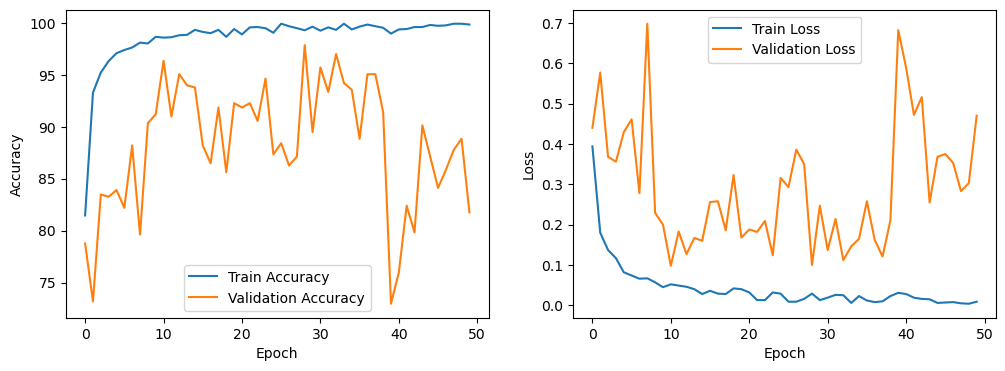

In [31]:
# 정확도 및 손실을 그래프로 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(effb1_train_acc_lst, label='Train Accuracy')
plt.plot(effb1_val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(effb1_train_loss_lst, label='Train Loss')
plt.plot(effb1_val_loss_lst, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### fc.layer 전이학습 ver

In [32]:
train_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=448, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [33]:
valid_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 경로 설정
dataset_path = 'C://Users/user/Desktop/딥러닝/project_ms'

# ImageFolder를 사용하여 전체 데이터셋을 불러옵니다.
train_dataset = ImageFolder(dataset_path + '/train', transform=train_transforms)
val_dataset = ImageFolder(dataset_path + '/val', transform=valid_transforms)
# test_dataset = ImageFolder(dataset_path + '/test', transform=test_transforms)

# DataLoader 설정
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [36]:
import time

# 학습 시작 시간 기록
start_time = time.time()

model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=2)
model = model.to(device)

# 모델의 Convolution 층을 학습 가능하도록 설정
start_training = False  # 학습 시작 플래그

for name, param in model.named_parameters():
    if '_fc.weight' in name:  # 학습을 시작할 층의 이름을 식별
        start_training = True
    if start_training:
        param.requires_grad = True
    else:
        param.requires_grad = False

# 필요한 옵티마이저 정의
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()

# 리스트 초기화
effb1_train_acc_lst = []
effb1_train_loss_lst = []
effb1_val_acc_lst = []
effb1_val_loss_lst = []

state = {}

# 모델 훈련
epochs = 50
for epoch in range(1, epochs+1):

    train_loss = 0
    total = 0
    correct = 0
    train_acc = 0

    model.train()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스 선택
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()

    train_loss = round(train_loss / len(train_loader), 3)  # 미니배치 수로 나누어 평균을 계산
    train_acc = round((train_acc / total) * 100, 2)  # 백분율로 변환

    print(f'Trainset {epoch}/{epochs} Loss: {train_loss}, Accuracy: {train_acc}%')
    effb1_train_acc_lst.append(train_acc)
    effb1_train_loss_lst.append(train_loss)

    # 검증 데이터셋에 대한 손실과 정확도 계산
    val_loss = 0
    val_total = 0
    val_correct = 0
    val_acc = 0

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_acc += (predicted == labels).sum().item()

    val_loss = round(val_loss / len(val_loader), 3)  # 검증 데이터셋의 손실 평균 계산
    val_acc = round((val_acc / val_total) * 100, 2)  # 검증 데이터셋의 정확도 계산

    print(f'Validation {epoch}/{epochs} Loss: {val_loss}, Accuracy: {val_acc}%')
    print()

    effb1_val_acc_lst.append(val_acc)
    effb1_val_loss_lst.append(val_loss)

    if np.max(effb1_val_acc_lst) <= val_acc:
        state['epoch'] = epoch
        state['net'] = model.state_dict()

        state['train_loss'] = train_loss
        state['val_loss'] = val_loss

        state['train_acc'] = train_acc
        state['val_acc'] = val_acc

end_time = time.time()

# 전체 학습 시간 계산 (종료 시간 - 시작 시간)
training_time_seconds = end_time - start_time

# 시, 분, 초로 변환
training_time_minutes = training_time_seconds // 60
training_time_hours = training_time_minutes // 60

print(f"Total training time: {training_time_seconds} seconds")
print(f"Total training time: {training_time_minutes} minutes")
print(f"Total training time: {training_time_hours} hours")
print(f"Total training time: {training_time_hours} H {training_time_minutes - (60 * training_time_hours)} m")

# 모델 저장
torch.save(state, 'C://Users/user/Desktop/딥러닝/학습모델/fc.layer_전이_마송_448_efficientb1_{}_{}.pth'.format(str(state['epoch']), str(state['val_acc'])))

Loaded pretrained weights for efficientnet-b1
Trainset 1/50 Loss: 0.642, Accuracy: 67.51%
Validation 1/50 Loss: 0.772, Accuracy: 25.32%

Trainset 2/50 Loss: 0.571, Accuracy: 77.47%
Validation 2/50 Loss: 0.81, Accuracy: 27.47%

Trainset 3/50 Loss: 0.531, Accuracy: 78.3%
Validation 3/50 Loss: 0.832, Accuracy: 30.04%

Trainset 4/50 Loss: 0.501, Accuracy: 80.47%
Validation 4/50 Loss: 0.849, Accuracy: 31.55%

Trainset 5/50 Loss: 0.485, Accuracy: 79.96%
Validation 5/50 Loss: 0.846, Accuracy: 31.12%

Trainset 6/50 Loss: 0.475, Accuracy: 80.47%
Validation 6/50 Loss: 0.832, Accuracy: 34.55%

Trainset 7/50 Loss: 0.439, Accuracy: 82.53%
Validation 7/50 Loss: 0.823, Accuracy: 39.48%

Trainset 8/50 Loss: 0.426, Accuracy: 83.68%
Validation 8/50 Loss: 0.831, Accuracy: 39.7%

Trainset 9/50 Loss: 0.413, Accuracy: 84.07%
Validation 9/50 Loss: 0.815, Accuracy: 40.77%

Trainset 10/50 Loss: 0.411, Accuracy: 83.79%
Validation 10/50 Loss: 0.805, Accuracy: 41.2%

Trainset 11/50 Loss: 0.396, Accuracy: 83.75%
V

##### Acc and Loss 시각화

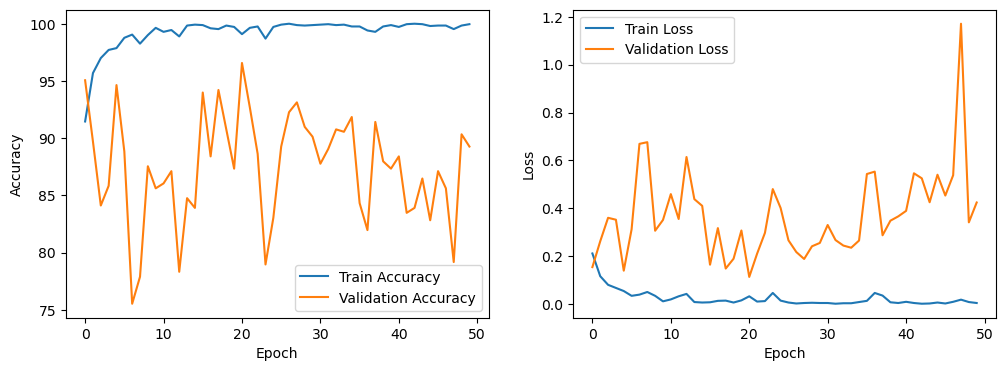

In [43]:
# 정확도 및 손실을 그래프로 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(effb1_train_acc_lst, label='Train Accuracy')
plt.plot(effb1_val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(effb1_train_loss_lst, label='Train Loss')
plt.plot(effb1_val_loss_lst, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### fc.layer 층 추가 ver

In [8]:
train_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=448, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
valid_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 경로 설정
dataset_path = 'C://Users/user/Desktop/딥러닝/project_ms'

# ImageFolder를 사용하여 전체 데이터셋을 불러옵니다.
train_dataset = ImageFolder(dataset_path + '/train', transform=train_transforms)
val_dataset = ImageFolder(dataset_path + '/val', transform=valid_transforms)
# test_dataset = ImageFolder(dataset_path + '/test', transform=test_transforms)

# DataLoader 설정
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [50]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
import torch
import numpy as np

# 기존 모델 로드
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=2)

# 모델의 마지막 FC 층의 입력 특성 수 가져오기
in_features = model._fc.in_features

# 첫 번째 새로운 FC 층 정의
new_fc1 = nn.Linear(in_features, 500)  # 100은 첫 번째 새로운 FC 층의 출력 특성 수
dropout1 = nn.Dropout(0.5) 
new_fc2 = nn.Linear(500, 100)  # 50은 두 번째 새로운 FC 층의 출력 특성 수
dropout2 = nn.Dropout(0.5) 
new_fc3 = nn.Linear(100, 2)  # 2는 마지막 FC 층의 출력 특성 수

# 새로운 FC 층과 Dropout 층을 모델에 설정
model._fc = nn.Sequential(new_fc1, nn.ReLU(), dropout1, new_fc2, nn.ReLU(), dropout2, new_fc3)

# 모델을 GPU 또는 CPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 리스트 초기화
effb1_train_acc_lst = []
effb1_train_loss_lst = []
effb1_val_acc_lst = []
effb1_val_loss_lst = []

state = {}

# 모델 훈련
epochs = 50
for epoch in range(1, epochs+1):

    train_loss = 0
    total = 0
    correct = 0
    train_acc = 0

    model.train()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)  # 가장 높은 확률을 가진 클래스 선택
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()

    train_loss = round(train_loss / len(train_loader), 3)  # 미니배치 수로 나누어 평균을 계산
    train_acc = round((train_acc / total) * 100, 2)  # 백분율로 변환

    print(f'Trainset {epoch}/{epochs} Loss: {train_loss}, Accuracy: {train_acc}%')
    effb1_train_acc_lst.append(train_acc)
    effb1_train_loss_lst.append(train_loss)

    # 검증 데이터셋에 대한 손실과 정확도 계산
    val_loss = 0
    val_total = 0
    val_correct = 0
    val_acc = 0

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_acc += (predicted == labels).sum().item()

    val_loss = round(val_loss / len(val_loader), 3)  # 검증 데이터셋의 손실 평균 계산
    val_acc = round((val_acc / val_total) * 100, 2)  # 검증 데이터셋의 정확도 계산

    print(f'Validation {epoch}/{epochs} Loss: {val_loss}, Accuracy: {val_acc}%')
    print()

    effb1_val_acc_lst.append(val_acc)
    effb1_val_loss_lst.append(val_loss)

    if np.max(effb1_val_acc_lst) <= val_acc:
        state['epoch'] = epoch
        state['net'] = model.state_dict()

        state['train_loss'] = train_loss
        state['val_loss'] = val_loss

        state['train_acc'] = train_acc
        state['val_acc'] = val_acc

end_time = time.time()

# 전체 학습 시간 계산 (종료 시간 - 시작 시간)
training_time_seconds = end_time - start_time

# 시, 분, 초로 변환
training_time_minutes = training_time_seconds // 60
training_time_hours = training_time_minutes // 60

print(f"Total training time: {training_time_seconds} seconds")
print(f"Total training time: {training_time_minutes} minutes")
print(f"Total training time: {training_time_hours} hours")
print(f"Total training time: {training_time_hours} H {training_time_minutes - (60 * training_time_hours)} m")

# 모델 저장
torch.save(state, 'C://Users/user/Desktop/딥러닝/학습모델/newlayer_마송_448_efficientb1_{}_{}.pth'.format(str(state['epoch']), str(state['val_acc'])))

Loaded pretrained weights for efficientnet-b1
Trainset 1/50 Loss: 0.449, Accuracy: 76.84%
Validation 1/50 Loss: 0.48, Accuracy: 79.18%

Trainset 2/50 Loss: 0.15, Accuracy: 94.94%
Validation 2/50 Loss: 0.198, Accuracy: 91.42%

Trainset 3/50 Loss: 0.101, Accuracy: 95.65%
Validation 3/50 Loss: 0.7, Accuracy: 76.82%

Trainset 4/50 Loss: 0.069, Accuracy: 97.63%
Validation 4/50 Loss: 1.301, Accuracy: 68.24%

Trainset 5/50 Loss: 0.064, Accuracy: 97.98%
Validation 5/50 Loss: 1.249, Accuracy: 58.8%

Trainset 6/50 Loss: 0.077, Accuracy: 98.02%
Validation 6/50 Loss: 0.74, Accuracy: 74.68%

Trainset 7/50 Loss: 0.044, Accuracy: 98.62%
Validation 7/50 Loss: 0.682, Accuracy: 78.11%

Trainset 8/50 Loss: 0.059, Accuracy: 98.85%
Validation 8/50 Loss: 1.51, Accuracy: 64.59%

Trainset 9/50 Loss: 0.036, Accuracy: 98.77%
Validation 9/50 Loss: 0.356, Accuracy: 90.13%

Trainset 10/50 Loss: 0.023, Accuracy: 99.13%
Validation 10/50 Loss: 0.571, Accuracy: 80.9%

Trainset 11/50 Loss: 0.03, Accuracy: 99.13%
Valida

##### Acc and Loss 시각화

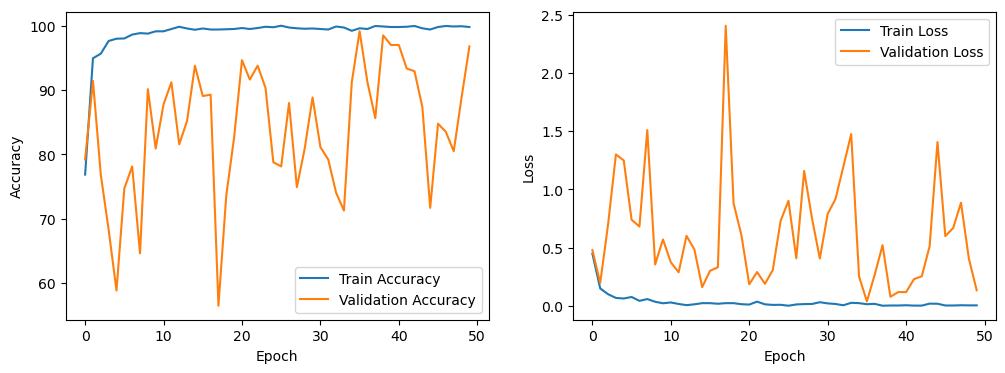

In [51]:
# 정확도 및 손실을 그래프로 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(effb1_train_acc_lst, label='Train Accuracy')
plt.plot(effb1_val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(effb1_train_loss_lst, label='Train Loss')
plt.plot(effb1_val_loss_lst, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 폴더 데이터 체크

In [5]:
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# 모델 불러오기
model_path = '/content/drive/MyDrive/연예인 사진 분류/new_so_aug_448_efficientb1_26_96.27.pth'

# 모델 정의 (모델 아키텍처와 동일하게 정의해야 함)
model = EfficientNet.from_name('efficientnet-b1', num_classes=2)
model.to(device)

# 저장된 모델 가중치 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['net'])
model.eval()

# 폴더 경로 설정
image_folder = '/content/drive/MyDrive/얼굴분류/test'  # 이미지 파일들이 있는 폴더 경로

# 폴더 내의 모든 이미지 파일 리스트
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('.jpg', '.jpeg', '.png'))]

# 데이터 전처리 변환
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # 모델에 맞는 이미지 크기로 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = ["김태희", "김혜수"]

# 결과를 저장할 리스트 초기화
results = []

# 이미지 파일들에 대한 예측
for image_path in image_files:
    with torch.no_grad():
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)

        output = model(image)
        probabilities = torch.softmax(output, dim=1)[0].cpu().numpy()
        predicted_class = np.argmax(probabilities)
        predicted_class_name = class_names[predicted_class]  # 예측 클래스 이름
        predicted_class_probs = dict(zip(class_names, probabilities))  # 클래스 이름과 확률을 딕셔너리로 저장

        results.append({
            'image_path': image_path,
            'predicted_class': predicted_class_name,
            'predicted_class_probs': predicted_class_probs
        })

# 시각화
images_per_page = 10
for i in range(0, len(results), images_per_page):
    plt.figure(figsize=(30, 20))
    for j, result in enumerate(results[i:i + images_per_page]):
        plt.subplot(5, 2, j + 1)
        image = Image.open(result['image_path'])
        plt.imshow(image)
        plt.title(f"Class: {result['predicted_class']}\nProbabilities: {result['predicted_class_probs']}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### 이미지 한장 체크

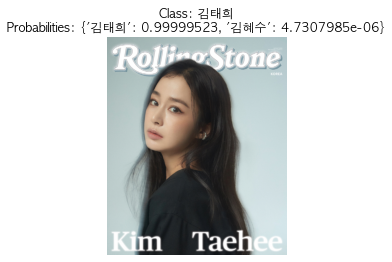

In [ ]:
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# 모델 불러오기
model_path = '/Users/taeyoung/Desktop/딥러닝/new_so_aug_448_efficientb1_26_96.27.pth'

# 모델 정의 (모델 아키텍처와 동일하게 정의해야 함)
model = EfficientNet.from_name('efficientnet-b1', num_classes=2)
model.to(device)

# 저장된 모델 가중치 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['net'])
model.eval()

# 이미지 파일 경로 설정
image_path = '/Users/taeyoung/Desktop/딥러닝/test/김태희_test_5.jpeg'  # 단일 이미지 파일 경로

# 데이터 전처리 변환
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # 모델에 맞는 이미지 크기로 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = ["김태희", "김혜수"]

# 이미지에 대한 예측
with torch.no_grad():
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    output = model(image)
    probabilities = torch.softmax(output, dim=1)[0].cpu().numpy()
    predicted_class = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class]  # 예측 클래스 이름
    predicted_class_probs = dict(zip(class_names, probabilities))  # 클래스 이름과 확률을 딕셔너리로 저장

# 시각화
plt.figure(figsize=(8, 4))
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Class: {predicted_class_name}\nProbabilities: {predicted_class_probs}")
plt.axis('off')
plt.show()

### 테스트 데이터 체크

In [ ]:
# import torch
# import torch.nn as nn
# from efficientnet_pytorch import EfficientNet
# import torch.optim as optim
# import matplotlib.pyplot as plt
# import numpy as np
# from PIL import Image


# # 저장된 모델 가중치 파일의 경로
# model_path = '/Users/taeyoung/Desktop/딥러닝/new_so_aug_448_efficientb1_26_96.27.pth'

# # 모델 정의
# model = EfficientNet.from_name('efficientnet-b1', num_classes=2)  # 4개의 클래스를 가진 모델로 수정
# model.to(device)

# checkpoint = torch.load(model_path, map_location=device)
# model.load_state_dict(checkpoint['net'], strict=False)

# # 출력층 변경
# model._fc = nn.Linear(model._fc.in_features, 4)
# model.eval()
# model.to(device)

# class_names = ["김태희", "김혜수", "마동석", "송중기"]

# results = []

# # 테스트 데이터에 대한 예측 및 확률 저장
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)

#         # 소프트맥스 함수를 사용하여 클래스별 예측 확률 계산
#         probs = torch.softmax(outputs, dim=1)
#         class_probs = probs.cpu().numpy()

#         for i in range(len(images)):
#             predicted_class_probs = dict(zip(class_names, class_probs[i]))
#             results.append({
#                 'predicted_class': class_names[np.argmax(class_probs[i])],
#                 'predicted_class_probs': predicted_class_probs
#             })

# # 이미지 시각화
# images_per_page = 10  # 한 페이지에 표시할 이미지 수
# num_pages = (len(results) + images_per_page - 1) // images_per_page

# for page in range(num_pages):
#     fig, axes = plt.subplots(images_per_page // 1, 1, figsize=(40, 40))
#     axes = axes.ravel()

#     for i in range(images_per_page):
#         index = page * images_per_page + i
#         if index < len(results):
#             predicted_class = results[index]['predicted_class']
#             predicted_class_probs = results[index]['predicted_class_probs']

#             # 이미지 파일 가져오기
#             image_path = test_loader.dataset.samples[index][0]
#             image = Image.open(image_path)

#             # 예측 확률을 소수점 두 자리까지 표시
#             formatted_probs = {k: f"{v:.2f}" for k, v in predicted_class_probs.items()}

#             # 이미지 시각화
#             axes[i].imshow(image)
#             axes[i].set_title(f'Predicted Class: {predicted_class}\nProbabilities: {formatted_probs}')
#             axes[i].axis('off')

#     plt.tight_layout()
#     plt.show()